In [1]:
# Requires xarray_sentinel environment

import os
import sys 
import glob
import pyproj
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp

In [2]:
# importing from one directory  up
sys.path.insert(0, "../" )
from misc import round_to_hour, angular_difference, calculate_distance

In [3]:
# TODO perform analysis (averaging) along axis to see whether noise is present since no denoising is performed
# NOTE We assume a recitilinear geometry with no range migration 
#   NOTE within 60km azimuth the maximum slant-range distance change is approx 1km (+1km and -1km)

The geometric Doppler is calculated as

\begin{equation}
    f_{d,\mathrm{geom}}\left(Az,Rg\right) = \frac{2V_{\mathrm{LOS}} \cdot \sin\left( \Delta\theta_{Az} \left(Az,Rg\right) \right)}{\lambda}
\end{equation}

with $\Delta \theta$ being the azimuthal angle difference w.r.t the boresight direction down range

\begin{equation}
\tag{2}
    w_{\sigma_0}\left(Az,Rg\right) = \frac{\sigma_{0}\left(Az,Rg\right)}{\left<\sigma_0\left(Az,Rg\right) \right>_{Az}}
\end{equation}

$w_{\sigma_0}$ the local backscatter weight with $\left<\sigma_0\left(Az,Rg\right) \right>_{Az}$ being the along-azimuth average

\begin{equation}
    \beta_{\mathrm{Az}}\left(Az,Rg\right) = \mathrm{sinc}^2\left(\frac{L_A}{\lambda \Delta\theta_{Az}\left(Az,Rg\right)} \right)
\end{equation}

\begin{equation}

    \beta_{\mathrm{Rg}}\left(Az,Rg\right) = \mathrm{sinc}^2\left(\frac{H_A }{\lambda \Delta\theta_{Rg}\left(Az,Rg\right)} \right)
\end{equation}

Assuming a sinc-like beam pattern with $L_A$ and $H_A$ being the antenna length and height respectively

\begin{equation}
    \beta\left(Az,Rg\right) = \beta_{\mathrm{Az}}\left(Az,Rg\right)  \cdot \beta_{\mathrm{Rg}}\left(Az,Rg\right)
\end{equation}

Integrating over the full beam pattern along azimuth yields the leakage dependent LOS velocity, $V_{\mathrm{leakage}}$

\begin{equation}
    V_{\mathrm{leakage}} \left(Rg\right)= \frac{\lambda}{2} 
    \frac
        {\int \frac{f_{d,\mathrm{geom}}}{\sin\left(\theta_{\mathrm{inc}}\right)} \cdot \beta \cdot w_{\sigma_0} \ dAz}
        {\int \beta \cdot w_{\sigma_0} \ dAz}
\end{equation}

Repeating for several pulses yields the slow time, range dependent $V_{\mathrm{leakage}} \left(p, Rg\right)$



In [39]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"

f0 = 5.3E9
z0 = 700E3
c = 3E8
Lambda = c / f0 # # NOTE play with different centre frequency
length_antenna = 3.2
height_antenna = 0.3
incidence_angle_scat = 40
incidence_angle_scat_boresight = 45
vx_sat = 6800 
PRF = 4
stride = vx_sat / PRF
az_mask_cutoff = 200_000 # m
resolution_spatial = 340 # m
scene_size = 25_000

az_mask_pixels_cutoff = int(az_mask_cutoff/2//resolution_spatial) 
grg_N = int(scene_size // resolution_spatial)           # number of fast-time samples to avreage to scene size
slow_time_N = int(scene_size // stride)                 # number of slow-time samples to avreage to scene size

In [22]:
# Load files
files = glob.glob(f"{data_dir}*")
# NRCS = grd_to_nrcs(files[2], prod_res=resolution_spatial,  denoise=True)

# NRCS0 = grd_to_nrcs(files[0], prod_res=resolution_spatial,  denoise=True)
# NRCS1 = grd_to_nrcs(files[1], prod_res=resolution_spatial,  denoise=True)
# # NRCS2 = grd_to_nrcs(files[2], prod_res=resolution_spatial,  denoise=True)
# # NRCS3 = grd_to_nrcs(files[3], prod_res=resolution_spatial,  denoise=True) # FIXME broken
# # NRCS4 = grd_to_nrcs(files[4], prod_res=resolution_spatial,  denoise=True)
# NRCS5 = grd_to_nrcs(files[5], prod_res=resolution_spatial,  denoise=True)
# # NRCS6 = grd_to_nrcs(files[6], prod_res=resolution_spatial,  denoise=True)

NRCS = xr.merge([NRCS0, NRCS1,NRCS5])


In [25]:
# Select date and location to querry ERA5
path = '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/'
date = NRCS.azimuth_time.min().values.astype('datetime64[m]').astype(object)
date_rounded = round_to_hour(date)

yy, mm, dd, hh = date_rounded.year, date_rounded.month, date_rounded.day, date_rounded.hour
latmin = latmax = NRCS.latitude.mean().data*1
lonmin = lonmax = NRCS.longitude.mean().data*1

era5_filename = getera5(latmin, latmax, lonmin, lonmax, yy, mm, dd, hh, path=path, retrieve=True)

In [27]:
# Compute wind speed and direction from ERA5
filename = 'era520201110.nc'#era5_filename.split(path)[1]
era5 = xr.open_dataset(filename)
u10, v10 = np.ravel(era5.u10.values*1)[0], np.ravel(era5.v10.values*1)[0]
wdir_era5 = np.rad2deg(np.arctan2(u10, v10))

# Compute orientation of observation
lats, lons = NRCS.latitude.values, NRCS.longitude.values
geodesic = pyproj.Geod(ellps='WGS84')
ground_dir, _, _ = geodesic.inv(lons[0, 0], lats[0, 0], lons[-1,0], lats[-1,0])

# compute directional difference between satelite and era5 wind direction
wdir_wrt_sensor = angular_difference(ground_dir, wdir_era5)

In [28]:
# create dataframe with coordinates from scatterometer 
grg_offset = np.tan(np.deg2rad(incidence_angle_scat)) * z0
grg = np.arange(NRCS.latitude.data.shape[1]) * resolution_spatial + grg_offset
az = (np.arange(NRCS.latitude.data.shape[0]) - NRCS.latitude.data.shape[0]//2) * resolution_spatial
x_sat = np.arange(az.min(), az.max(), stride)

data = xr.Dataset(
    data_vars=dict(
        nrcs = (["az", "grg"], NRCS.NRCS_VV.data, {'units': 'm2/m2'}),
        inc = (["az", "grg"], NRCS.inc.data, {'units': 'Degrees'}),
        x_sat = (["slow_time"], x_sat)
    ),
    coords=dict(
        az = (["az"], az, {'units': 'm'}),
        grg = (["grg"], grg, {'units': 'm'}),
    ),
    attrs=dict(wdir_wrt_sensor=wdir_wrt_sensor),
)

In [30]:
# convert S1 backscatter to windfield and back to equivalent scatterometer backscatter
windfield = cmod5n_inverse(data.nrcs.values, data.wdir_wrt_sensor, data.inc.values)
windfield = np.tile(windfield,  data.slow_time.shape + (1,1)) # expand the windfield from 2D to 3D
data['windfield'] = (["slow_time", "az", "grg"], windfield, {'units': 'm/s'})

def windfield_over_slow_time(data_subset):
    result = cmod5n_forward(data_subset.windfield.values, data_subset.wdir_wrt_sensor, data_subset.inc_scatt_eqv.values)
    data_subset['nrcs_scatt'] = (["az", "grg"], result, {'units': 'm/s'})
    return data_subset

# calculate surface distance between sensor and point on surface as well as equivalent incidence angle for sensor
data['distance_ground'] = calculate_distance(x = data.az, y = data.grg, x0 = data.x_sat) 
data['inc_scatt_eqv'] = np.rad2deg(np.arctan(data['distance_ground']/z0))
data = data.groupby('slow_time').apply(windfield_over_slow_time).transpose('az', 'grg', 'slow_time')

In [31]:
# NOTE weight is calculated per azimuth line in burst (slow time)
# NOTE weight is linearly scaled with relative nrcs (e.g. local nrcs of twice the average will yield weight of 2.0)

# compute relative weight from backscatter
data['nrcs_weight'] = (data.nrcs_scatt / data.nrcs_scatt.mean(dim=['az', 'grg'])) 
data['distance_slant_range'] = np.sqrt(data['distance_ground']**2 + z0**2)
data['az_angle_wrt_boresight'] = np.arcsin((- data.x_sat + data.az )/data['distance_slant_range']) # incidence from boresight
data['grg_angle_wrt_boresight'] = np.deg2rad(data['inc_scatt_eqv'] - incidence_angle_scat_boresight)
data = data.transpose('az', 'grg', 'slow_time')

# calculate beam patterns
beam_rg = sinc_bp(np.sin(data['az_angle_wrt_boresight']), L=length_antenna, f0=f0)
beam_az = sinc_bp(np.sin(data['grg_angle_wrt_boresight']), L=height_antenna, f0=f0)
data['beam_grg'] = (['az', 'grg', 'slow_time'], beam_rg)
data['beam_az'] = (['az', 'grg', 'slow_time'], beam_az)
data['beam_grg_az'] = data['beam_grg'] * data['beam_az']

In [40]:
# compute beam mask around 
top_row = np.abs(data['beam_grg_az'].sum(dim='grg')).argmax(axis=0).values
masks = []
for i in top_row:
    mask = np.zeros_like(data['az'])  # create a mask
    lower_limit = np.where(i-az_mask_pixels_cutoff < 0, 0, i-az_mask_pixels_cutoff)
    mask[lower_limit:i+az_mask_pixels_cutoff+1] = 1
    masks.append(mask)

temp = xr.Dataset(
    data_vars=dict(
        temp1 = (["az","slow_time"], np.array(masks).T), 
        temp2 = (["grg"], np.ones_like(data.grg))),
    coords=dict(
        az=(["az"], data['az'].values),
        grg=(["grg"], data['grg'].values),
        time_slow=(["slow_time"], data['slow_time'].values),),
)

data['beam_mask'] = temp.temp1 * temp.temp2

In [41]:
data['dop_geom'] = (2 * vx_sat * np.sin(data.az_angle_wrt_boresight) / Lambda) # eq. 4.34 from Digital Procesing of Synthetic Aperture Radar Data by Ian G. Cummin
data['beam'] = data['beam_grg_az'] * data['beam_mask'] 
data['dop_beam_weighted'] = data['dop_geom'] * data['beam']* data['nrcs_weight']
data['V_leakage'] = Lambda * data['dop_beam_weighted'] / (2 * np.sin(np.deg2rad(data['inc_scatt_eqv']))) # using the equivalent scatterometer incidence angle

weight_rg = (data['beam'] * data['nrcs_weight']).sum(dim='az')
receive_rg = data[['dop_beam_weighted', 'V_leakage']].sum(dim='az')
data[['doppler_pulse_rg', 'V_leakage_pulse_rg']] = receive_rg / weight_rg #(data['dop_beam_weighted']/data['beam']).mean(dim='az').T 
data['beam_cutoff'] = data['beam'].sum(dim = ['az', 'grg'])/ data['beam'].sum(dim = ['az', 'grg']).max() < 0.9995
data[['doppler_pulse_rg', 'V_leakage_pulse_rg']][dict(slow_time=data['beam_cutoff'])] = np.nan
data['V_leakage_pulse_rg'] = data['V_leakage_pulse_rg'].assign_attrs(units= 'm/s', description = 'Line of sight velocity ')
subscenes = data[['doppler_pulse_rg', 'V_leakage_pulse_rg']].coarsen(grg=grg_N, slow_time=slow_time_N, boundary='trim').mean(skipna=False) 

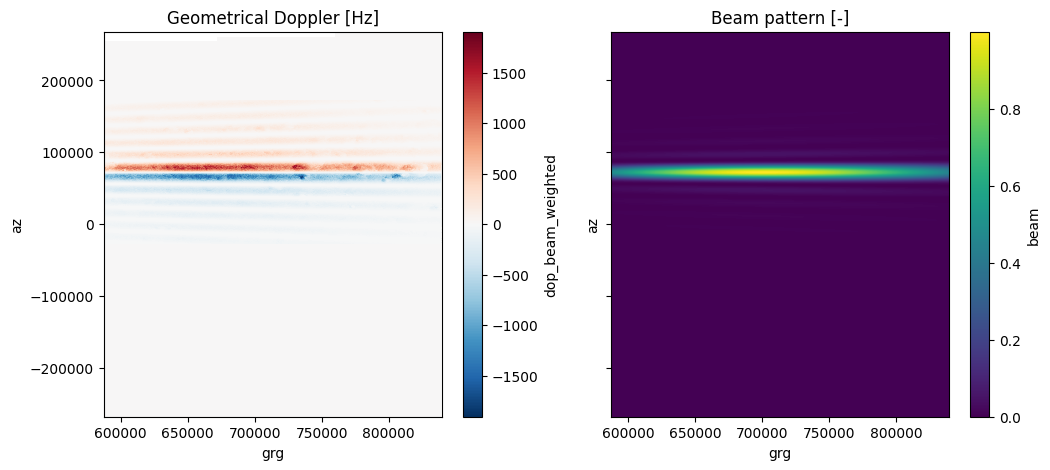

In [42]:
idx = 200
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
data['dop_beam_weighted'].isel(slow_time = idx).plot(ax = axes[0])
data['beam'].isel(slow_time = idx).plot(ax = axes[1])
axes[0].set_title('Geometrical Doppler [Hz]')
_ = axes[1].set_title('Beam pattern [-]')

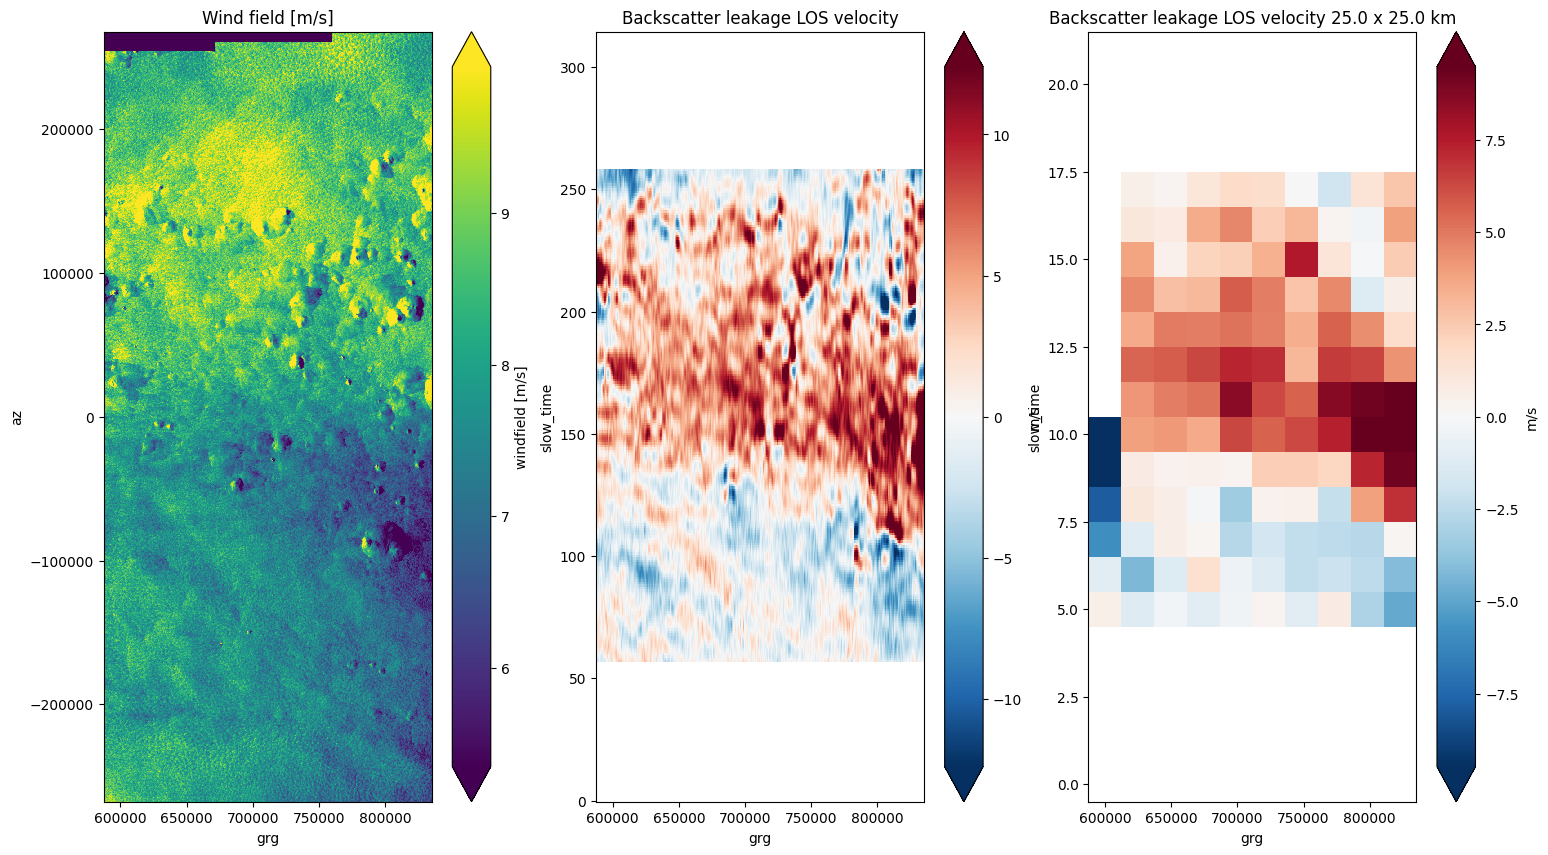

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10), sharex=True)
data.windfield.isel(slow_time=0).plot(robust= True, ax=axes[0])
data['V_leakage_pulse_rg'].T.plot(robust = True, ax=axes[1], cbar_kwargs={'label': data['V_leakage_pulse_rg'].attrs['units']})
subscenes['V_leakage_pulse_rg'].T.plot(robust = True, ax=axes[2], cbar_kwargs={'label': data['V_leakage_pulse_rg'].attrs['units']})
axes[0].set_title('Wind field [m/s]')
_ = axes[1].set_title('Backscatter leakage LOS velocity')
_ = axes[2].set_title(f'Backscatter leakage LOS velocity {scene_size/1000} x {scene_size/1000} km')